## LangGraph 提示词助手

+ 根据用户输入生成提示词并优化

In [1]:
import os
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_deepseek import ChatDeepSeek
from pydantic import BaseModel
from dotenv import load_dotenv

load_dotenv(".env", override=True)

llm = ChatDeepSeek(
    model=os.environ.get("DEEPSEEK_MODEL"),
    api_base=os.environ.get("DEEPSEEK_API_BASE"),
    api_key=os.environ.get("DEEPSEEK_API_KEY"),
    temperature=0.0,
)

template = """
你的工作是从用户那里获取有关他们想要创建的提示词模板类型的信息。

你应该从他们那里获取以下信息：

- 提示词的目标是什么
- 那些变量将被传递到提示词模板中
- 输出不应该做什么的任何约束
- 输出必须遵守的任何要求

如果你无法辨别这些信息，请要求他们澄清！不要尝试胡乱猜测。

在你能够辨别所有信息后，调用相关工具。
"""


def get_messages_info(messages):
    return [SystemMessage(content=template)] + messages


class PromptInstructions(BaseModel):
    """关于如何提示LLM的指令。"""

    objective: str  # 目标
    variables: list[str]  # 变量
    constraints: list[str]  # 约束
    requirements: list[str]  # 要求


llm_with_tool = llm.bind_tools([PromptInstructions])


def info_chain(state):
    messages = get_messages_info(state["messages"])
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [2]:
# 生成提示词
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

# 新系统提示词
prompt_system = """根据以下要求，编写一个好的提示词模板：

{reqs}"""


# 获取提示消息的函数
# 只会获取工具调用之后的消息
def get_prompt_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs


def prompt_gen_chain(state):
    messages = get_prompt_messages(state["messages"])
    response = llm.invoke(messages)
    return {"messages": [response]}

In [3]:
# 定义状态逻辑
from langgraph.graph import END


def get_state(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

In [ ]:
# 创建工作流
from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


memory = MemorySaver()

workflow = StateGraph(State)
workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_gen_chain)


@workflow.add_node
def add_tool_message(state):
    return {
        "messages": [
            ToolMessage(
                content="提示词创建成功！",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        ]
    }


workflow.add_conditional_edges("info", get_state, ["add_tool_message", "info", END])
workflow.add_edge("add_tool_message", "prompt")
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")

graph = workflow.compile(checkpointer=memory)

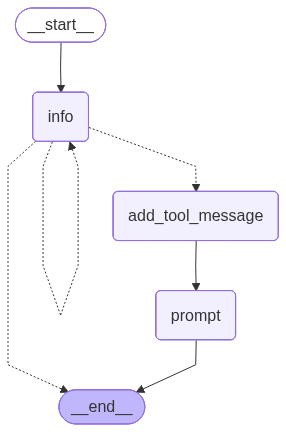

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
# Test
import uuid

cached_human_responses = ["hi!", "rag prompt", "1 rag, 2 none, 3 no, 4 no", "red", "q"]
cached_response_index = 0
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

while True:
    try:
        user = input("User (q/Q to quit): ")
    except:
        user = cached_human_responses[cached_response_index]
        cached_response_index += 1
    print(f"User (q/! to quit): {user}")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in graph.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))["messages"][-1]
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")


User (q/! to quit): 
================================== Ai Message ==================================

我需要了解您想要创建的提示词模板的具体信息，以便为您提供合适的帮助。

请告诉我：

1. **提示词的目标是什么？**（您希望这个提示词模板实现什么功能？）
2. **哪些变量将被传递到提示词模板中？**（用户需要提供哪些信息？）
3. **输出不应该做什么的任何约束？**（有哪些限制或不应该包含的内容？）
4. **输出必须遵守的任何要求？**（必须满足哪些条件或格式要求？）

请尽可能详细地描述这些信息，这样我就能为您创建最合适的提示词模板了。
User (q/! to quit): 目标：写作
================================== Ai Message ==================================

我理解了您的目标是"写作"，但这个描述比较宽泛。为了为您创建一个有效的写作提示词模板，我需要更具体的信息：

1. **写作的具体目标是什么？**
   - 是写小说、文章、诗歌、报告、邮件，还是其他类型的文本？
   - 写作的主题或领域是什么？（如科技、文学、商业等）

2. **哪些变量将被传递到提示词模板中？**
   - 用户需要提供哪些具体信息？（如主题、字数、风格、目标读者等）
   - 例如：主题、字数要求、写作风格、目标受众等

3. **输出不应该做什么的任何约束？**
   - 有哪些内容应该避免？（如避免使用专业术语、避免政治敏感话题等）
   - 格式上的限制？（如不能超过特定字数、不能使用某些词汇等）

4. **输出必须遵守的任何要求？**
   - 必须满足哪些条件？（如必须包含特定结构、必须使用正式语言等）
   - 格式要求？（如需要标题、段落结构、引用格式等）

请提供这些详细信息，这样我就能为您创建一个专门针对您写作需求的提示词模板了。
User (q/! to quit): 写作目标是：变量为标题和写作风格，约束条件是不超过20个字，具体要求是使用绝句
================================== Ai Message ==========